**Problem 1: Supervised Classification Libraries: Regression, Decision Tree**

6 Runs of Supervised Training / Testing : 3 datasets (MNIST, Spambase, 20NG) x 2 Classification Algorithms (L2-reg Logistic Regression, Decision Trees). You can use a library for the classification algorithms, and also can use any library/script to process data in appropriate formats.
You are required to explain/analyze the model trained in terms of features : for each of the 6 runs list the top F=30 features. For the Regression these correspond to the highest-absolute-value F coefficients; for Decision Tree they are the first F splits. In particular for Decision Tree on 20NG, report performance for two tree sizes ( by depths of the tree, or number of leaves, or number of splits )

In [3]:
import numpy as np
from collections import deque
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def get_top_features_logistic(model, feature_names=None, F=30):
    """
    For logistic regression: Returns the top F features
    sorted by absolute value of the coefficients.
    If feature_names is provided, return names with coefficients.
    """
    # For binary classification, coef_ is shape (1, n_features)
    coef = model.coef_[0]
    abs_coef = np.abs(coef)
    top_indices = np.argsort(abs_coef)[-F:][::-1]
    if feature_names is not None:
        top_features = [(feature_names[i], coef[i]) for i in top_indices]
    else:
        top_features = [(i, coef[i]) for i in top_indices]
    return top_features

def get_top_splits(decision_tree, F=30):
    """
    For decision trees: Traverse the tree in breadth-first order
    and return the feature indices for the first F splits.
    Leaf nodes have feature index -2.
    """
    tree = decision_tree.tree_
    q = deque([0])  # Start from the root node (index 0)
    splits = []
    while q and len(splits) < F:
        node = q.popleft()
        # Check if current node is a split (non-leaf)
        if tree.feature[node] != -2:
            splits.append(tree.feature[node])
            # Enqueue children nodes (if they exist)
            left_child = tree.children_left[node]
            right_child = tree.children_right[node]
            if left_child != -1:
                q.append(left_child)
            if right_child != -1:
                q.append(right_child)
    return splits

def run_classification(X, y, feature_names=None, dataset_name="Dataset"):
    print(f"\n {dataset_name}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print("\nLogistic Regression")
    lr = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    print(f"Accuracy: {acc_lr:.4f}")
    top_lr_features = get_top_features_logistic(lr, feature_names)
    print("Top 30 features (by coefficient magnitude):")
    for feature, coef in top_lr_features:
        print(f"Feature: {feature}, Coefficient: {coef}")

    print("\nDecision Tree")
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    acc_dt = accuracy_score(y_test, y_pred_dt)
    print(f"Accuracy: {acc_dt:.4f}")
    top_dt_splits = get_top_splits(dt)
    print("Top 30 splits (in order of appearance):")
    for i, feat in enumerate(top_dt_splits):
        if feature_names is not None and feat < len(feature_names):
            feat_name = feature_names[feat]
        else:
            feat_name = feat
        print(f"Split {i+1}: Feature: {feat_name}")

def run_mnist():
    print("Loading MNIST dataset")
    # MNIST from openml; scale pixel values to [0,1]
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.astype(np.float32) / 255.0
    y = mnist.target.astype(np.int64)
    # Create feature names for pixels
    feature_names = [f"pixel_{i}" for i in range(X.shape[1])]
    run_classification(X, y, feature_names, dataset_name="MNIST")

def run_spambase():
    print("Loading Spambase dataset")
    # The dataset is comma-separated, with the last column as the target.
    data = np.loadtxt("spambase.data", delimiter=",")
    X = data[:, :-1]
    y = data[:, -1]
    # Create feature names for spambase features
    feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    run_classification(X, y, feature_names, dataset_name="Spambase")

def run_20newsgroups():
    print("Loading 20 Newsgroups dataset")
    # Load train and test splits; remove headers/footers/quotes to focus on content.
    newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
    newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
    # Use TfidfVectorizer to convert text to feature vectors (limit features for speed)
    vectorizer = TfidfVectorizer(max_features=2000)
    X_train = vectorizer.fit_transform(newsgroups_train.data)
    X_test = vectorizer.transform(newsgroups_test.data)
    # Combine train and test to allow our own splitting
    from scipy.sparse import vstack
    X = vstack([X_train, X_test])
    y = np.concatenate([newsgroups_train.target, newsgroups_test.target])
    feature_names = vectorizer.get_feature_names_out()

    print("\n20 Newsgroups (Logistic Regression)")
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)
    lr = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
    lr.fit(X_tr, y_tr)
    y_pred_lr = lr.predict(X_te)
    acc_lr = accuracy_score(y_te, y_pred_lr)
    print(f"Accuracy: {acc_lr:.4f}")
    top_lr_features = get_top_features_logistic(lr, feature_names)
    print("Top 30 features (by coefficient magnitude):")
    for feature, coef in top_lr_features:
        print(f"Feature: {feature}, Coefficient: {coef}")

    print("\n20 Newsgroups (Decision Tree)")

    # Configuration 1: Shallow Tree (max_depth=5)
    print("\nDecision Tree (Shallow: max_depth=5)")
    dt_shallow = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt_shallow.fit(X_tr, y_tr)
    y_pred_shallow = dt_shallow.predict(X_te)
    acc_shallow = accuracy_score(y_te, y_pred_shallow)
    print(f"Accuracy: {acc_shallow:.4f}")
    top_splits_shallow = get_top_splits(dt_shallow)
    print("Top 30 splits (Shallow Tree):")
    for i, feat in enumerate(top_splits_shallow):
        feat_name = feature_names[feat] if feat < len(feature_names) else feat
        print(f"Split {i+1}: Feature: {feat_name}")

    # Configuration 2: Deep Tree (max_depth=15)
    print("\nDecision Tree (Deep: max_depth=15)")
    dt_deep = DecisionTreeClassifier(max_depth=15, random_state=42)
    dt_deep.fit(X_tr, y_tr)
    y_pred_deep = dt_deep.predict(X_te)
    acc_deep = accuracy_score(y_te, y_pred_deep)
    print(f"Accuracy: {acc_deep:.4f}")
    top_splits_deep = get_top_splits(dt_deep)
    print("Top 30 splits (Deep Tree):")
    for i, feat in enumerate(top_splits_deep):
        feat_name = feature_names[feat] if feat < len(feature_names) else feat
        print(f"Split {i+1}: Feature: {feat_name}")

if __name__ == "__main__":
    # Run experiments on MNIST
    run_mnist()

    # Run experiments on Spambase
    run_spambase()

    # Run experiments on 20 Newsgroups
    run_20newsgroups()

Loading MNIST dataset...

=== MNIST ===

-- Logistic Regression --
Accuracy: 0.9155
Top 30 features (by coefficient magnitude):
Feature: pixel_379, Coefficient: -2.140631880246161
Feature: pixel_517, Coefficient: -1.724224949896848
Feature: pixel_710, Coefficient: -1.6411961929051553
Feature: pixel_305, Coefficient: -1.5838818330965132
Feature: pixel_461, Coefficient: -1.5161776873412551
Feature: pixel_712, Coefficient: -1.4760219309135363
Feature: pixel_715, Coefficient: -1.4701182900734062
Feature: pixel_222, Coefficient: -1.4373566837046465
Feature: pixel_718, Coefficient: -1.41116516174984
Feature: pixel_177, Coefficient: -1.3643682506328025
Feature: pixel_249, Coefficient: -1.3559286839744613
Feature: pixel_102, Coefficient: -1.346720288565536
Feature: pixel_489, Coefficient: -1.3217004157337955
Feature: pixel_192, Coefficient: -1.315472231315428
Feature: pixel_714, Coefficient: -1.2855499217760067
Feature: pixel_250, Coefficient: -1.2788168791521628
Feature: pixel_164, Coefficien

**Problem 2: PCA library on MNIST**

A) For MNIST dataset, run a PCA-library to get data on D=5 features. Rerun the classification tasks from PB1, compare testing performance with the one from PB1. Then repeat this exercise for D=20
B) Run PCA library on Spambase and repeat one of the classification algorithms. What is the smallest D (number of PCA dimensions) you need to get a comparable test result?

In [4]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
def run_mnist_pca(D):
    print(f"\nMNIST with PCA (D = {D})")
    # Load MNIST and normalize pixel values
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.astype(np.float32) / 255.0
    y = mnist.target.astype(np.int64)

    # Apply PCA to reduce to D dimensions
    pca = PCA(n_components=D)
    X_pca = pca.fit_transform(X)
    print(f"Explained Variance Ratio Sum (D = {D}): {pca.explained_variance_ratio_.sum():.4f}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

    # Logistic Regression
    lr = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    print(f"Logistic Regression Accuracy with PCA (D = {D}): {acc_lr:.4f}")

    # Decision Tree
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    acc_dt = accuracy_score(y_test, y_pred_dt)
    print(f"Decision Tree Accuracy with PCA (D = {D}): {acc_dt:.4f}")

# Run experiments for D=5 and D=20
run_mnist_pca(5)
run_mnist_pca(20)


 MNIST with PCA (D=5)
Explained Variance Ratio Sum (D=5): 0.3334
Logistic Regression Accuracy with PCA (D=5): 0.6450
Decision Tree Accuracy with PCA (D=5): 0.6730

 MNIST with PCA (D=20)
Explained Variance Ratio Sum (D=20): 0.6447
Logistic Regression Accuracy with PCA (D=20): 0.8624
Decision Tree Accuracy with PCA (D=20): 0.8425


In [6]:
def run_spambase_pca():
    print("\nSpambase PCA Experiments")
    # Load Spambase
    data = np.loadtxt("spambase.data", delimiter=",")
    X = data[:, :-1]
    y = data[:, -1]

    # Baseline: Logistic Regression without PCA
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    lr_baseline = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
    lr_baseline.fit(X_train, y_train)
    y_pred_baseline = lr_baseline.predict(X_test)
    baseline_acc = accuracy_score(y_test, y_pred_baseline)
    print(f"Baseline (No PCA) Logistic Regression Accuracy: {baseline_acc:.4f}")

    # Determine smallest D with comparable performance
    # Define "comparable" as being within 2% (absolute difference) of the baseline accuracy.
    threshold = baseline_acc - 0.02
    best_D = None
    for D in range(2, X.shape[1] + 1):
        pca = PCA(n_components=D)
        X_pca = pca.fit_transform(X)
        X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
        lr = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
        lr.fit(X_train_pca, y_train)
        y_pred = lr.predict(X_test_pca)
        acc = accuracy_score(y_test, y_pred)
        print(f"PCA D = {D}: Accuracy = {acc:.4f}")
        if acc >= threshold:
            best_D = D
            print(f"Smallest D with comparable performance (within 2% of baseline): {D}")
            break
    if best_D is None:
        print("No PCA dimension achieved comparable performance to baseline.")

# Run the Spambase PCA experiment
run_spambase_pca()


 Spambase PCA Experiments
Baseline (No PCA) Logistic Regression Accuracy: 0.9319
PCA D = 2: Accuracy = 0.7183
PCA D = 3: Accuracy = 0.7169
PCA D = 4: Accuracy = 0.7784
PCA D = 5: Accuracy = 0.7864
PCA D = 6: Accuracy = 0.8233
PCA D = 7: Accuracy = 0.8588
PCA D = 8: Accuracy = 0.8537
PCA D = 9: Accuracy = 0.8552
PCA D = 10: Accuracy = 0.8537
PCA D = 11: Accuracy = 0.8631
PCA D = 12: Accuracy = 0.8660
PCA D = 13: Accuracy = 0.8979
PCA D = 14: Accuracy = 0.9022
PCA D = 15: Accuracy = 0.9001
PCA D = 16: Accuracy = 0.8979
PCA D = 17: Accuracy = 0.8986
PCA D = 18: Accuracy = 0.9022
PCA D = 19: Accuracy = 0.9037
PCA D = 20: Accuracy = 0.9037
PCA D = 21: Accuracy = 0.9030
PCA D = 22: Accuracy = 0.9022
PCA D = 23: Accuracy = 0.9015
PCA D = 24: Accuracy = 0.9073
PCA D = 25: Accuracy = 0.9073
PCA D = 26: Accuracy = 0.9088
PCA D = 27: Accuracy = 0.9095
PCA D = 28: Accuracy = 0.9109
PCA D = 29: Accuracy = 0.9102
PCA D = 30: Accuracy = 0.9138
Smallest D with comparable performance (within 2% of bas

**Problem 3: Implement PCA on MNIST**

Repeat PB2 exercises on MNIST (D=5 and D=20) with your own PCA implementation. You can use any built-in library/package/API for : matrix storage/multiplication, covariance computation, eigenvalue or SVD decomposition, etc. Matlab is probably the easiest language for implementing PCA due to its excellent linear algebra support.


In [7]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def custom_pca(X, D):
    """
    Custom PCA implementation using SVD.

    Parameters:
      X : np.ndarray
          Data matrix of shape (n_samples, n_features)
      D : int
          Number of principal components to retain.

    Returns:
      X_pca : np.ndarray
          Data projected onto the top D principal components.
      components : np.ndarray
          Principal components (eigenvectors), shape (D, n_features).
      mu : np.ndarray
          Mean vector used for centering, shape (n_features,).
      S : np.ndarray
          Singular values from the SVD decomposition.
    """
    # Compute the mean of the data and center it.
    mu = np.mean(X, axis=0)
    X_centered = X - mu

    # Compute SVD on the centered data.
    # U: (n_samples, n_features), S: (min(n_samples, n_features),), Vt: (n_features, n_features)
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

    # The top D principal components are the first D rows of Vt.
    components = Vt[:D, :]

    # Project the centered data onto these D components.
    X_pca = np.dot(X_centered, components.T)

    return X_pca, components, mu, S

def run_mnist_custom_pca(D):
    print(f"\nMNIST with Custom PCA (D = {D})")
    # Load MNIST dataset and scale pixel values to [0, 1]
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.astype(np.float32) / 255.0
    y = mnist.target.astype(np.int64)

    # Apply our custom PCA to reduce to D dimensions.
    X_pca, components, mu, S = custom_pca(X, D)

    # Optionally compute the explained variance ratio.
    # Eigenvalues are (S**2) / (n_samples-1)
    eigenvalues = (S**2) / (X.shape[0] - 1)
    total_variance = np.sum(eigenvalues)
    explained_variance = np.sum(eigenvalues[:D])
    explained_ratio = explained_variance / total_variance
    print(f"Explained Variance Ratio (D = {D}): {explained_ratio:.4f}")

    # Split the PCA-transformed data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

    lr = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    print(f"Logistic Regression Accuracy with Custom PCA (D = {D}): {acc_lr:.4f}")

    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    acc_dt = accuracy_score(y_test, y_pred_dt)
    print(f"Decision Tree Accuracy with Custom PCA (D = {D}): {acc_dt:.4f}")

# Run experiments for D=5 and D=20.
run_mnist_custom_pca(5)
run_mnist_custom_pca(20)


MNIST with Custom PCA (D = 5)
Explained Variance Ratio (D = 5): 0.3334
Logistic Regression Accuracy with Custom PCA (D = 5): 0.6450
Decision Tree Accuracy with Custom PCA (D = 5): 0.6700

MNIST with Custom PCA (D = 20)
Explained Variance Ratio (D = 20): 0.6447
Logistic Regression Accuracy with Custom PCA (D = 20): 0.8624
Decision Tree Accuracy with Custom PCA (D = 20): 0.8410


**Problem 4: PCA for clustering visualization**

A) Run KMeans on MNIST data (or a sample of it)
B) Run PCA on same data
C) Plot data in 3D with PCA representation with t=3 top eigen values; use shapes to to indicate truth digit label (circle, triangle, "+", stars, etc) and colors to indicate cluster ID (red blue green etc).
D) Select other 3 at random eigen values from top 20; redo the plot several times.

Loading MNIST dataset...
KMeans clustering complete.
PCA complete.
Explained variance ratio (top 20 components):
[0.09607171 0.0697315  0.06215357 0.05601848 0.04912191 0.04278843
 0.03372084 0.02945185 0.02773615 0.02391314 0.02139929 0.02031304
 0.01705929 0.01669039 0.01624587 0.01533382 0.01368017 0.01286627
 0.01253526 0.01148484]


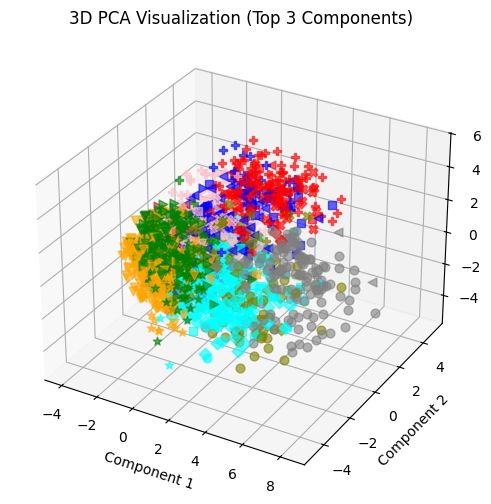

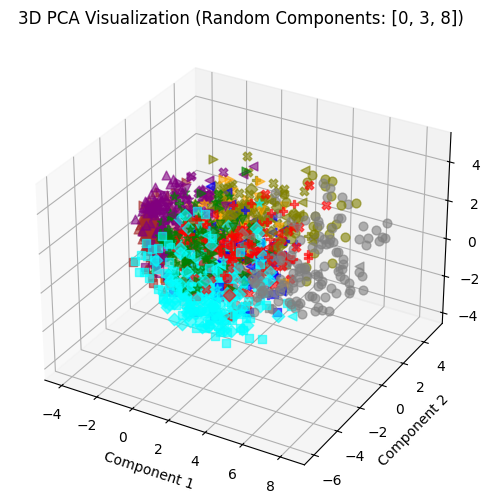

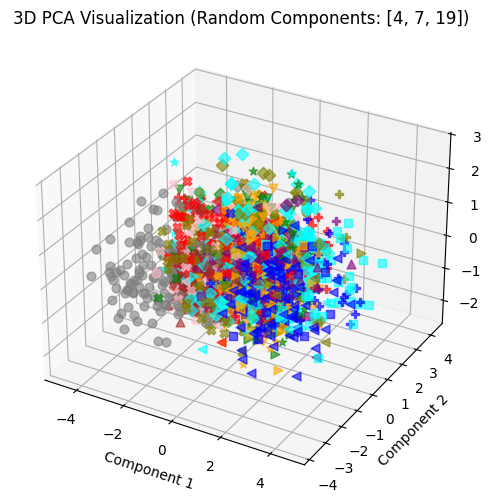

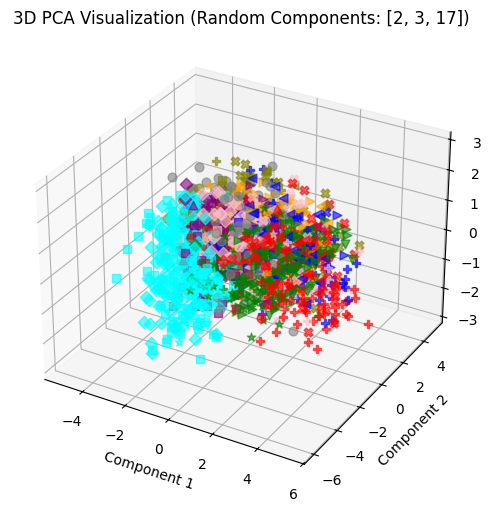

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("Loading MNIST dataset")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype(np.float32) / 255.0  # Scale pixel values to [0, 1]
y = mnist.target.astype(int)

# For faster computation/visualization, sample a subset (e.g., 2000 samples)
sample_size = 2000
indices = np.random.choice(X.shape[0], sample_size, replace=False)
X_sample = X[indices]
y_sample = y[indices]

# Run KMeans clustering (using 10 clusters for the 10 digits)
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_ids = kmeans.fit_predict(X_sample)
print("KMeans clustering complete.")

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_sample)
print("PCA complete.")
print("Explained variance ratio (top 20 components):")
print(pca.explained_variance_ratio_)

# Define marker shapes for each true digit (0-9)
marker_dict = {
    0: 'o', 1: '^', 2: 's', 3: 'P', 4: '*',
    5: 'X', 6: 'D', 7: 'v', 8: '<', 9: '>'
}
# Define colors for each cluster (10 clusters)
color_list = ['red', 'blue', 'green', 'orange', 'purple',
              'brown', 'pink', 'gray', 'olive', 'cyan']

def plot_3d(X_data, title):
    """
    Creates a 3D scatter plot.
    - Marker shape indicates the true digit label.
    - Marker color indicates the KMeans cluster assignment.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(X_data.shape[0]):
        true_label = y_sample[i]
        cluster = cluster_ids[i]
        marker = marker_dict[true_label]
        color = color_list[cluster]
        ax.scatter(X_data[i, 0], X_data[i, 1], X_data[i, 2],
                   marker=marker, color=color, s=40, alpha=0.6)

    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

# Plot using the top 3 PCA components (components 0, 1, 2)
plot_3d(X_pca[:, :3], '3D PCA Visualization (Top 3 Components)')

# D) Randomly Select 3 Components from the Top 20 and Re-plot
num_random_plots = 3

for i in range(num_random_plots):
    # Randomly select 3 distinct indices from the range [0, 20)
    random_indices = sorted(random.sample(range(20), 3))
    title = f'3D PCA Visualization (Random Components: {random_indices})'
    X_random = X_pca[:, random_indices]
    plot_3d(X_random, title)

**Problem 5: Implement Kernel PCA for Logistic Regression**

Dataset: 1000 2-dim datapoints TwoSpirals
Dataset: 1000 2-dim datapoints ThreeCircles

A) First, train a Linear/Logistic Regression (library, logistic if data labels are categories) and confirm that it doesnt work , i.e. it has a high classification error or high Root Mean Squared Error.

B) Run KernelPCA with Gaussian Kernel to obtain a representation of T features. For reference these steps we demoed in class (Matlab):
%get pairwise squared euclidian distance
X2 = dot(X,X,2);
DIST_euclid = bsxfun(@plus, X2, X2') - 2 * X * X';
% get a kernel matrix NxN
sigma = 3;
K = exp(-DIST_euclid/sigma);
%normalize the Kernel to correspond to zero-mean
U = ones(N)/ N ;
Kn = K - U*K -K*U + U*K*U ;
% obtain kernel eignevalues, vectors; then sort them with largest eig first
[V,D] = eig(Kn,'vector') ;
[D,sorteig] = sort(D,'descend') ;
V = V(:, sorteig);
% get the projection matrix
XG = Kn*V;
%get first 3 dimensions
X3G = XG(:,1:3);
%get first 20 dimensions
X20G = XG(:,1:20);
%get first 100 dimensions
X100G = XG(:,1:100);

C) Retrain the regression algorithm on the same data kernelized / dual form. How large T needs to be to get good performance?

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def generate_two_spirals(n_points=1000, noise=0.2):
    """
    Generate a Two Spirals dataset.
    Total points = n_points (half in each spiral).
    """
    n = n_points // 2
    # Generate angles between 0 and 3*pi
    theta = np.sqrt(np.random.rand(n)) * 3 * np.pi
    # First spiral
    x1 = theta * np.cos(theta) + np.random.randn(n) * noise
    y1 = theta * np.sin(theta) + np.random.randn(n) * noise
    # Second spiral
    x2 = -theta * np.cos(theta) + np.random.randn(n) * noise
    y2 = -theta * np.sin(theta) + np.random.randn(n) * noise

    X = np.vstack([np.column_stack([x1, y1]),
                   np.column_stack([x2, y2])])
    # Class labels: 0 for first spiral, 1 for second spiral.
    y = np.hstack([np.zeros(n), np.ones(n)])
    return X, y

def generate_three_circles(n_points=1000, noise=0.1):
    """
    Generate a Three Circles dataset.
    Total points = n_points, with approximately equal points per circle.
    """
    n = n_points // 3
    # Circle 1: radius around 1
    theta1 = 2 * np.pi * np.random.rand(n)
    r1 = 1 + noise * np.random.randn(n)
    x1 = r1 * np.cos(theta1)
    y1 = r1 * np.sin(theta1)

    # Circle 2: radius around 2
    theta2 = 2 * np.pi * np.random.rand(n)
    r2 = 2 + noise * np.random.randn(n)
    x2 = r2 * np.cos(theta2)
    y2 = r2 * np.sin(theta2)

    # Circle 3: radius around 3
    theta3 = 2 * np.pi * np.random.rand(n)
    r3 = 3 + noise * np.random.randn(n)
    x3 = r3 * np.cos(theta3)
    y3 = r3 * np.sin(theta3)

    X = np.vstack([np.column_stack([x1, y1]),
                   np.column_stack([x2, y2]),
                   np.column_stack([x3, y3])])
    # Class labels: 0, 1, and 2.
    y = np.hstack([np.zeros(n), np.ones(n), 2*np.ones(n)])
    return X, y

def run_raw_logistic_regression(X, y, dataset_name="Dataset"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Raw Logistic Regression on {dataset_name}: Accuracy = {acc:.4f}")
    return acc

# Generate datasets
X_spirals, y_spirals = generate_two_spirals(n_points=1000, noise=0.2)
X_circles, y_circles = generate_three_circles(n_points=1000, noise=0.1)

print("=== PART A: Raw Data Classification ===")
print("Two Spirals:")
run_raw_logistic_regression(X_spirals, y_spirals, "Two Spirals")
print("Three Circles:")
run_raw_logistic_regression(X_circles, y_circles, "Three Circles")

def kernel_pca(X, T, sigma=3):
    """
    Perform Kernel PCA using a Gaussian kernel.

    Parameters:
      X     : Input data, shape (N, d).
      T     : Number of kernel PCA features (dimensions) to keep.
      sigma : Parameter for the Gaussian kernel.

    Returns:
      X_proj: Projection of X onto the top T eigenvectors of the centered kernel.
      eigvals, eigvecs: Eigenvalues and eigenvectors (sorted in descending order).
      Kn    : Centered kernel matrix.
    """
    N = X.shape[0]
    # Compute pairwise squared Euclidean distances:
    X2 = np.sum(X**2, axis=1).reshape(-1, 1)
    DIST = X2 + X2.T - 2 * np.dot(X, X.T)

    # Compute the Gaussian (RBF) kernel matrix:
    K = np.exp(-DIST / sigma)

    # Center the kernel matrix:
    one_N = np.ones((N, N)) / N
    Kn = K - one_N @ K - K @ one_N + one_N @ K @ one_N

    # Compute eigen-decomposition of the centered kernel matrix:
    # (Kn is symmetric, so we can use eigh)
    eigvals, eigvecs = np.linalg.eigh(Kn)
    # Sort eigenvalues (and eigenvectors) in descending order:
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Compute the projection: the kernel principal components.
    X_proj = Kn @ eigvecs[:, :T]
    return X_proj, eigvals, eigvecs, Kn

# PART C: RETRAIN LOGISTIC REGRESSION ON KERNEL PCA FEATURES
def run_kernel_pca_experiment(X, y, dataset_name="Dataset", sigma=3, T_vals=[3, 20, 100]):
    print(f"\nKernel PCA + Logistic Regression on {dataset_name}")
    results = {}
    for T in T_vals:
        # Compute Kernel PCA with T dimensions.
        X_proj, eigvals, eigvecs, Kn = kernel_pca(X, T, sigma=sigma)
        # Split into training and testing sets.
        X_train, X_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.3, random_state=42)
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[T] = acc
        print(f"Kernel PCA with T={T}: Accuracy = {acc:.4f}")
    return results

print("\nPART B & C: Kernel PCA Experiments")
print("Two Spirals:")
results_spirals = run_kernel_pca_experiment(X_spirals, y_spirals, dataset_name="Two Spirals", sigma=3, T_vals=[3, 20, 100])
print("\nThree Circles:")
results_circles = run_kernel_pca_experiment(X_circles, y_circles, dataset_name="Three Circles", sigma=3, T_vals=[3, 20, 100])

=== PART A: Raw Data Classification ===
Two Spirals:
Raw Logistic Regression on Two Spirals: Accuracy = 0.6533
Three Circles:
Raw Logistic Regression on Three Circles: Accuracy = 0.3033

PART B & C: Kernel PCA Experiments
Two Spirals:

Kernel PCA + Logistic Regression on Two Spirals
Kernel PCA with T=3: Accuracy = 0.4967
Kernel PCA with T=20: Accuracy = 0.9767
Kernel PCA with T=100: Accuracy = 0.9867

Three Circles:

Kernel PCA + Logistic Regression on Three Circles
Kernel PCA with T=3: Accuracy = 1.0000
Kernel PCA with T=20: Accuracy = 1.0000
Kernel PCA with T=100: Accuracy = 1.0000


**PROBLEM 6 - OPTIONAL (no credit) : Implement Kernel PCA on MNIST**

A) First, add Gaussian noise to MNIST images.
B) Then rerun PCA on noisy images (D=5 and D=20) and inspect visually the images obtained by PCA representation
C) Run Kernel-PCA with the RBF Kernel (D=5 and D=20) on noisy images and observe better images visually.

Loading MNIST dataset...
Running classical PCA on noisy images
Displaying PCA reconstructions


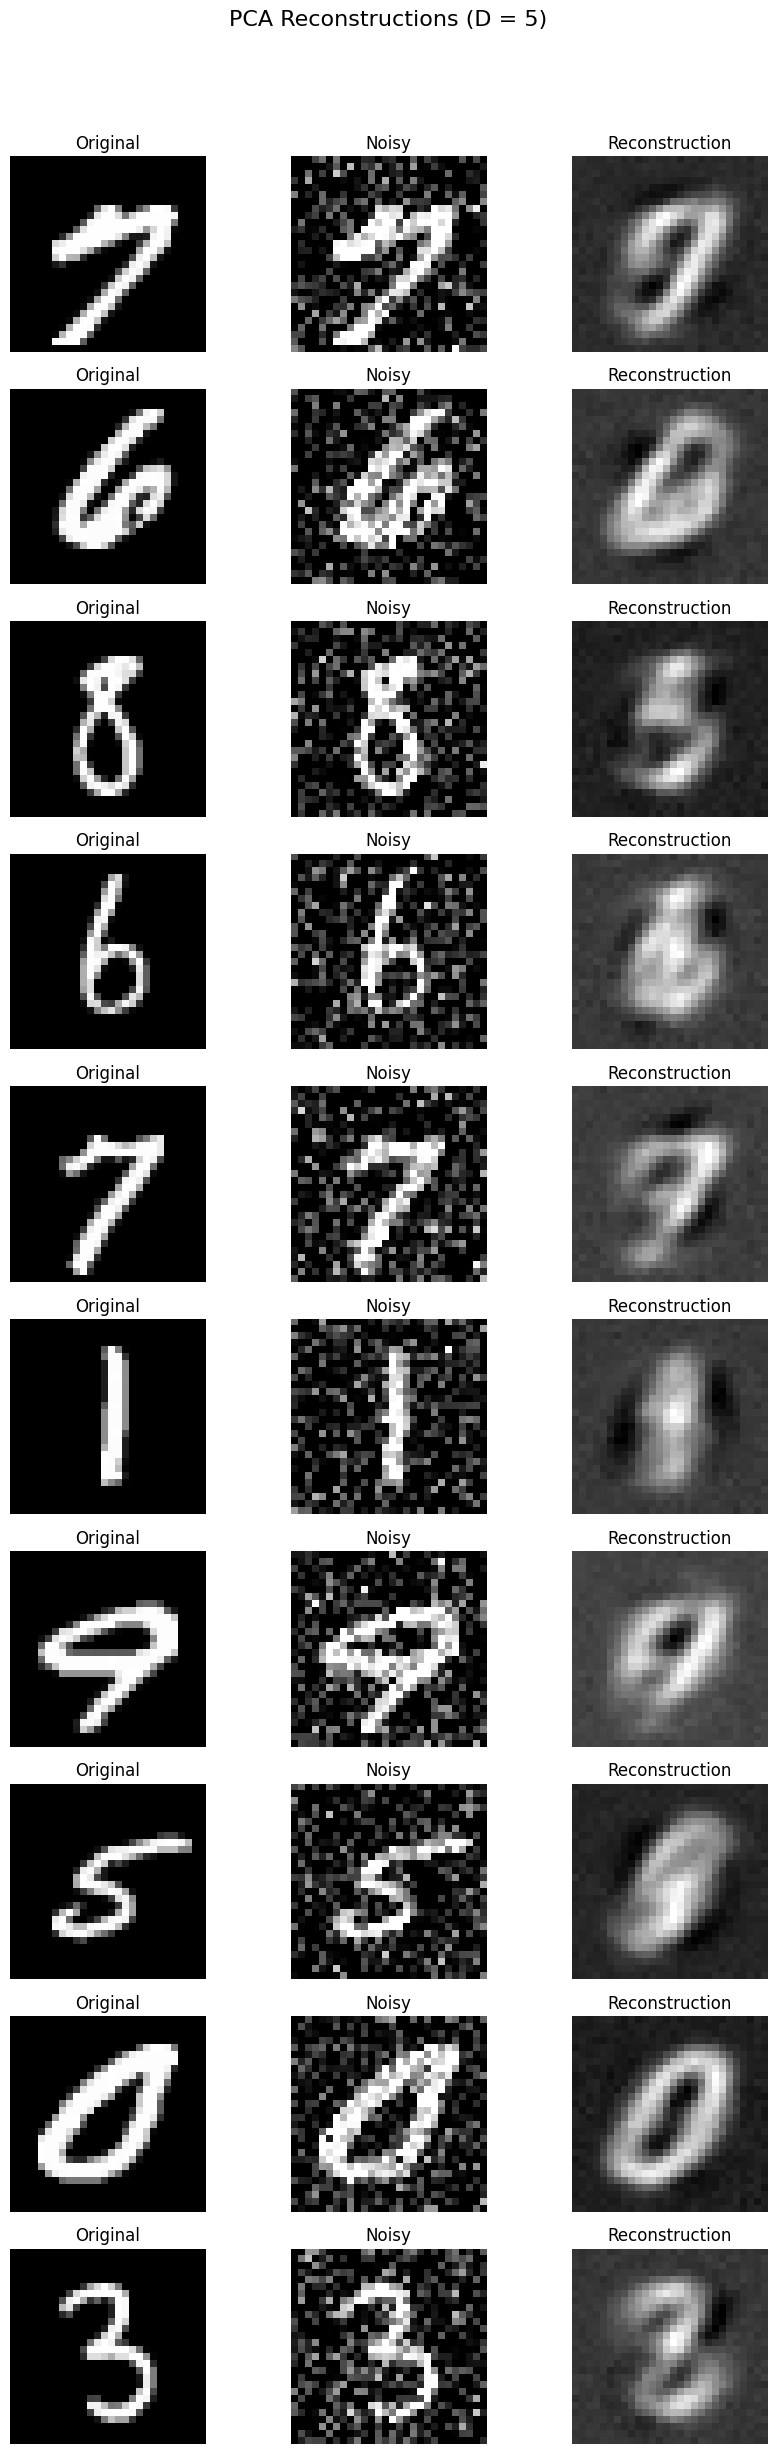

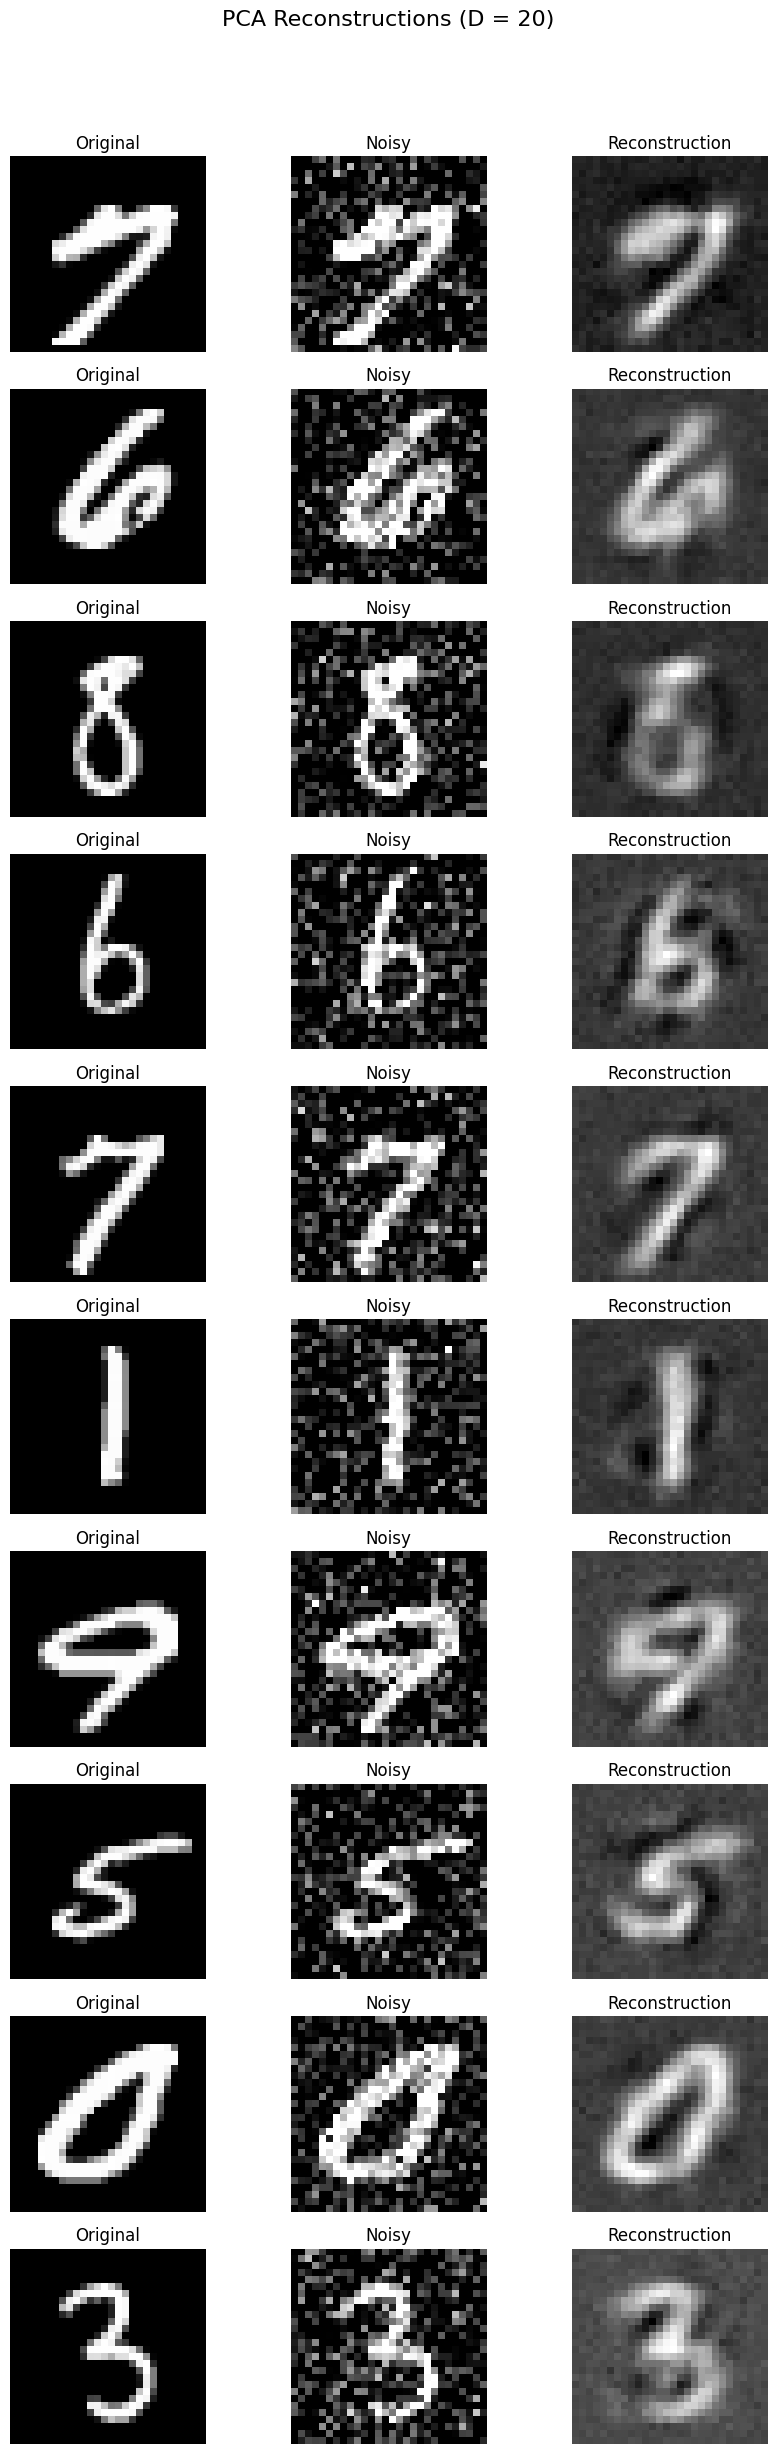

Using gamma = 0.004450593496200077
Running Kernel PCA on noisy images
Displaying Kernel PCA reconstructions


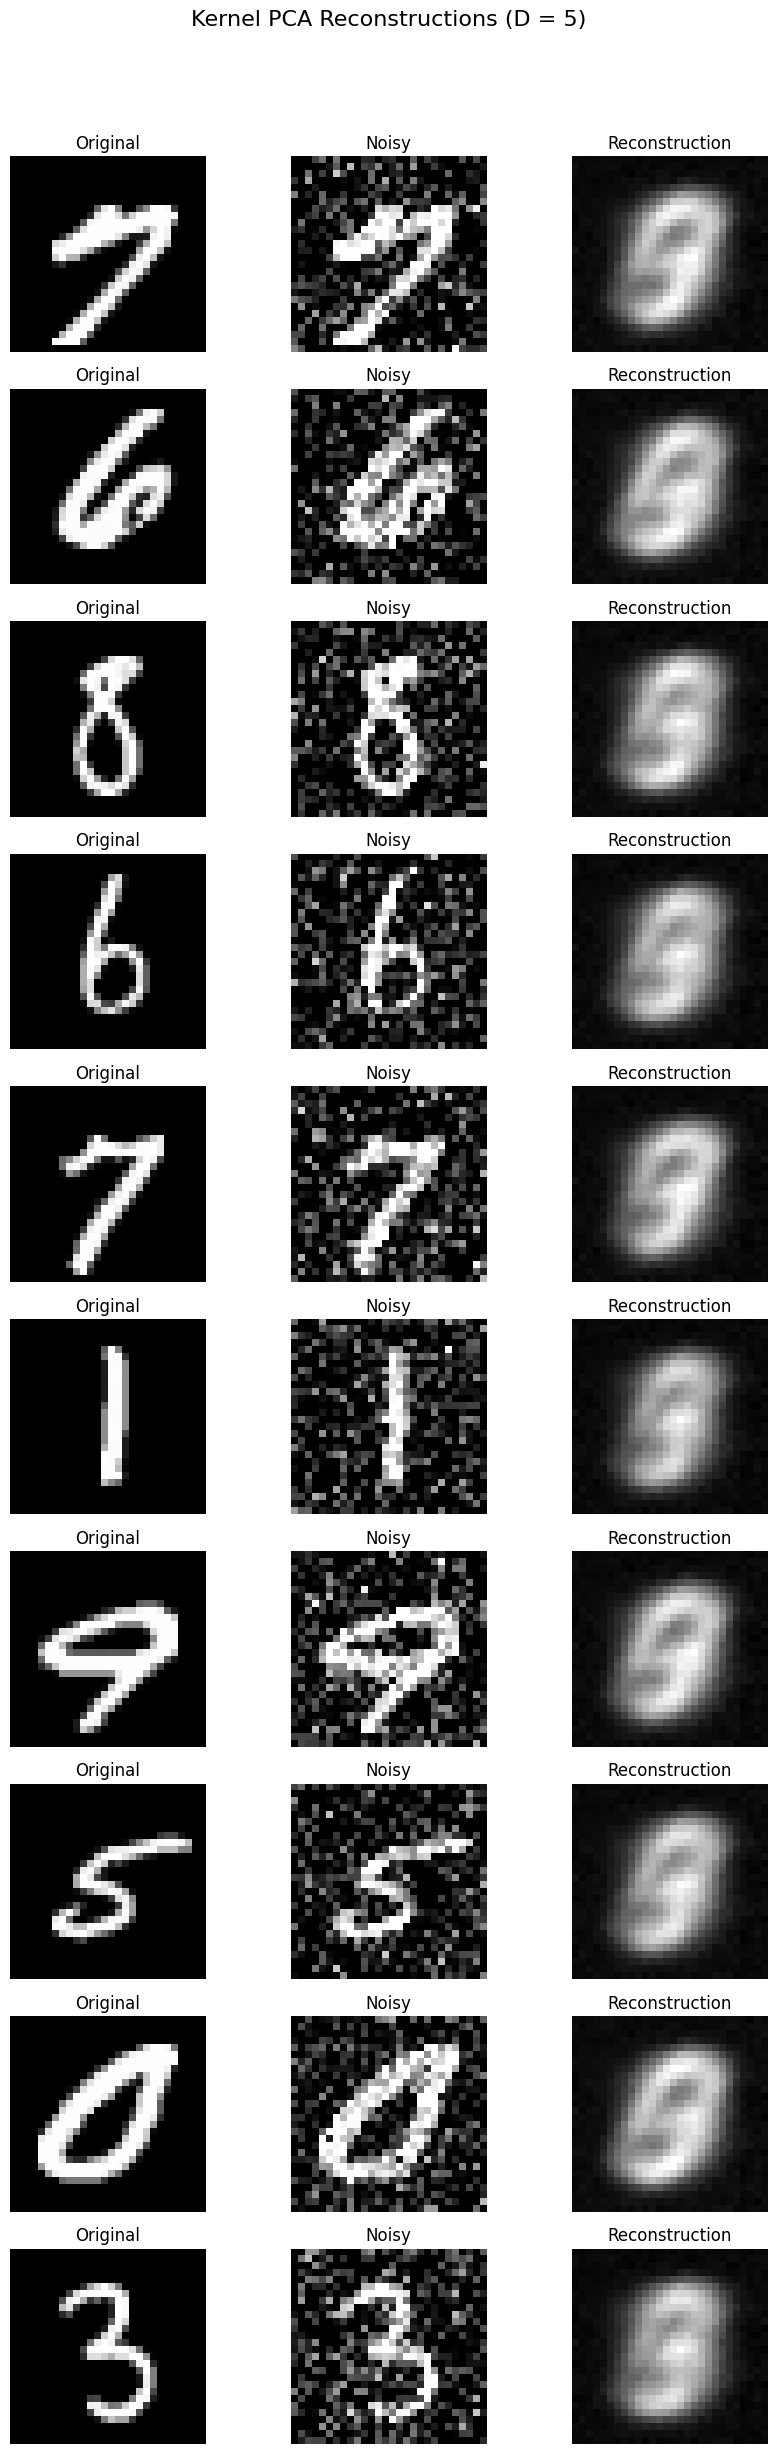

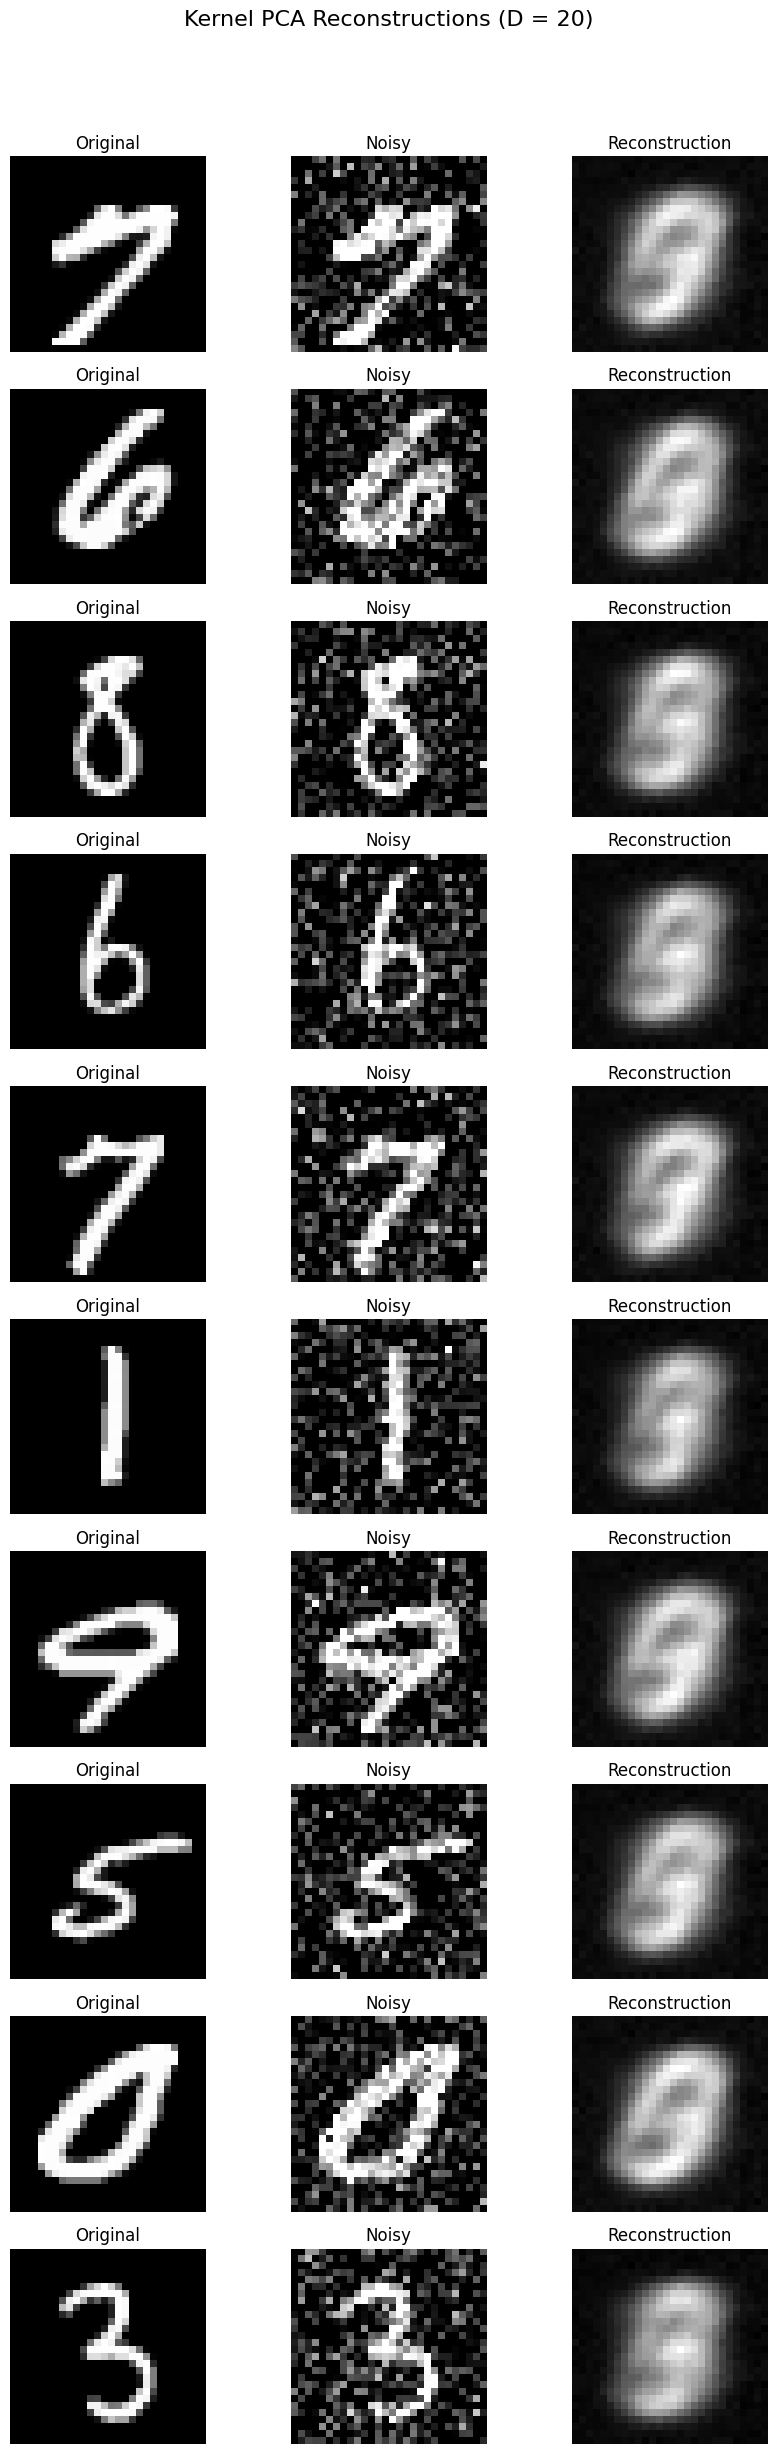

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics.pairwise import euclidean_distances

print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1)
# Convert to NumPy arrays and normalize to [0,1]
X = mnist.data.to_numpy().astype(np.float32) / 255.0
y = mnist.target.to_numpy().astype(np.int64)

# For speed, work with a subset (first 1000 images)
X = X[:1000]
n_samples, n_features = X.shape
img_shape = (28, 28)

# Add Gaussian noise
noise_std = 0.3
np.random.seed(42)
X_noisy = X + np.random.normal(0, noise_std, X.shape)
X_noisy = np.clip(X_noisy, 0, 1)  # Ensure pixel values remain in [0,1]

def plot_reconstructions(original, noisy, recon, title):
    """
    Plot a grid of images (rows for different samples, columns for: Original, Noisy, Reconstruction).
    """
    n_images = original.shape[0]
    fig, axes = plt.subplots(n_images, 3, figsize=(9, 2.5 * n_images))
    for i in range(n_images):
        # Original image
        axes[i, 0].imshow(original[i].reshape(img_shape), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        # Noisy image
        axes[i, 1].imshow(noisy[i].reshape(img_shape), cmap='gray')
        axes[i, 1].set_title('Noisy')
        axes[i, 1].axis('off')
        # Reconstruction image
        axes[i, 2].imshow(recon[i].reshape(img_shape), cmap='gray')
        axes[i, 2].set_title('Reconstruction')
        axes[i, 2].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Select 10 random images for visualization
np.random.seed(42)
indices = np.random.choice(X.shape[0], 10, replace=False)
orig_imgs = X[indices]
noisy_imgs = X_noisy[indices]

print("Running classical PCA on noisy images")

# PCA with D = 5
pca_5 = PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(X_noisy)
X_pca_5_recon = pca_5.inverse_transform(X_pca_5)

# PCA with D = 20
pca_20 = PCA(n_components=20)
X_pca_20 = pca_20.fit_transform(X_noisy)
X_pca_20_recon = pca_20.inverse_transform(X_pca_20)

print("Displaying PCA reconstructions")
plot_reconstructions(orig_imgs, noisy_imgs, X_pca_5_recon[indices], "PCA Reconstructions (D = 5)")
plot_reconstructions(orig_imgs, noisy_imgs, X_pca_20_recon[indices], "PCA Reconstructions (D = 20)")

def median_heuristic(X, subset=100):
    # Compute pairwise distances on a subset of samples
    dists = euclidean_distances(X[:subset])
    median_dist = np.median(dists)
    gamma = 1 / (2 * median_dist**2)
    return gamma

gamma_val = median_heuristic(X_noisy, subset=100)
print("Using gamma =", gamma_val)

# PART C: Kernel PCA on Noisy Images with the RBF Kernel (D=5 and D=20)
print("Running Kernel PCA on noisy images")

# Kernel PCA with D = 5
kpca_5 = KernelPCA(n_components=5, kernel='rbf', gamma=gamma_val,
                   fit_inverse_transform=True, eigen_solver='dense')
X_kpca_5 = kpca_5.fit_transform(X_noisy)
X_kpca_5_recon = kpca_5.inverse_transform(X_kpca_5)

# Kernel PCA with D = 20
kpca_20 = KernelPCA(n_components=20, kernel='rbf', gamma=gamma_val,
                    fit_inverse_transform=True, eigen_solver='dense')
X_kpca_20 = kpca_20.fit_transform(X_noisy)
X_kpca_20_recon = kpca_20.inverse_transform(X_kpca_20)

print("Displaying Kernel PCA reconstructions")
plot_reconstructions(orig_imgs, noisy_imgs, X_kpca_5_recon[indices], "Kernel PCA Reconstructions (D = 5)")
plot_reconstructions(orig_imgs, noisy_imgs, X_kpca_20_recon[indices], "Kernel PCA Reconstructions (D = 20)")